### Setup

In [1]:
import os
import pathlib

import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tf_keras

2025-05-05 20:24:49.844992: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 20:24:50.085024: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 20:24:50.270618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746456890.446628    5370 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746456890.490295    5370 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746456890.886317    5370 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
print(tf.__version__, tf_keras.__version__)

2.19.0 2.19.0


### Download the flowsers dataset

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
print(archive)
data_dir = pathlib.Path(os.path.join(archive, "flower_photos")).with_suffix('')
print(data_dir)

/home/paradox/.keras/datasets/flower_photos.tgz
/home/paradox/.keras/datasets/flower_photos.tgz/flower_photos


In [4]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


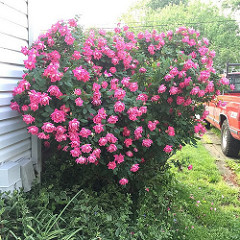

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

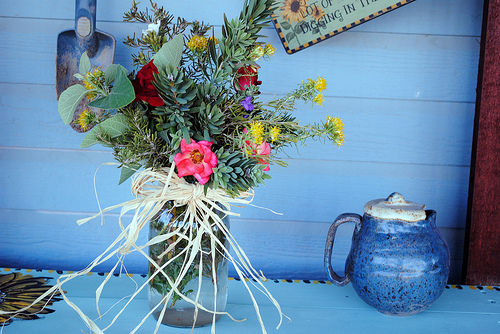

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

### Load data using a Keras utility

##### Create a dataset

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf_keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2025-05-05 20:25:11.323596: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
val_ds = tf_keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

In [11]:
import matplotlib.pyplot as plt

2025-05-05 20:28:49.077686: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


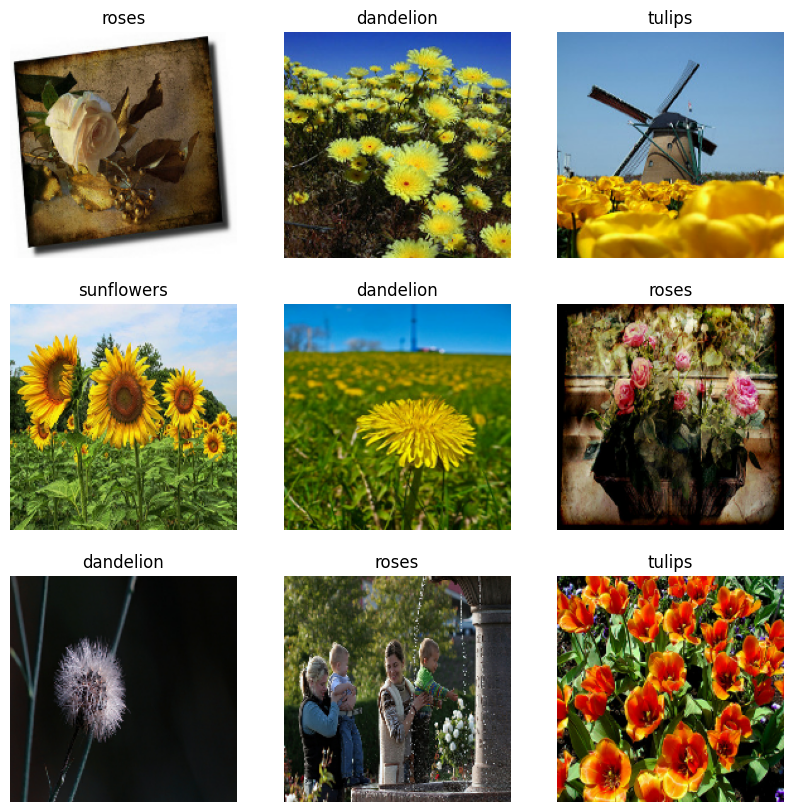

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9): 
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Standardize the data

In [14]:
normalization_layer = tf_keras.layers.Rescaling(1. / 255)


Applying normalization layer using `Dataset.map()`

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# The pixel values are now in `[0, 1]`.

print(np.min(first_image), np.max(first_image))

0.0 0.96902645


Secondly, we can directly apply the rescaling layer in the models definition.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

##### Train a model

In [18]:
num_classes = 5

model = tf_keras.Sequential([
    tf_keras.layers.Rescaling(1./255),
    tf_keras.layers.Conv2D(32, 3, activation="relu"),
    tf_keras.layers.MaxPooling2D(),
    tf_keras.layers.Conv2D(32, 3, activation='relu'),
    tf_keras.layers.MaxPooling2D(),
    tf_keras.layers.Conv2D(32, 3, activation="relu"),
    tf_keras.layers.MaxPool2D(),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(128, activation="relu"),
    tf_keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
    optimizer='adam',
    loss=tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 84s 900ms/step - loss: 1.3051 - accuracy: 0.4452 - val_loss: 1.0486 - val_accuracy: 0.5886
Epoch 2/3
92/92 [==============================] - 68s 742ms/step - loss: 1.0279 - accuracy: 0.5862 - val_loss: 0.9208 - val_accuracy: 0.6437
Epoch 3/3
92/92 [==============================] - 68s 746ms/step - loss: 0.8697 - accuracy: 0.6604 - val_loss: 0.7076 - val_accuracy: 0.7459


### Using tf.data for their control

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/paradox/.keras/datasets/flower_photos.tgz/flower_photos/dandelion/8376558865_19c5cd6fd6_n.jpg'
b'/home/paradox/.keras/datasets/flower_photos.tgz/flower_photos/tulips/2535936698_78cc03df3f_n.jpg'
b'/home/paradox/.keras/datasets/flower_photos.tgz/flower_photos/daisy/3475870145_685a19116d.jpg'
b'/home/paradox/.keras/datasets/flower_photos.tgz/flower_photos/roses/466486216_ab13b55763.jpg'
b'/home/paradox/.keras/datasets/flower_photos.tgz/flower_photos/roses/14107161906_5737e0e4ec.jpg'


2025-05-05 22:55:48.750907: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
class_names = np.array(sorted([data.name for data in data_dir.glob("*") if data.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [31]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [32]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [34]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encoded the label
    return tf.argmax(one_hot)

In [35]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])